In [43]:
#Árvore de decisão e floresta randômica

In [44]:
#importa a biblioteca que cria a seção do spark
from pyspark.sql import SparkSession 

In [45]:
#inicia a seção para a utilização do spark
spark = SparkSession\
    .builder\
    .appName("ArvoreDecisao")\
    .getOrCreate() #cria a seção caso não exista ou obtém a já criada

In [46]:
#define o diretório que contém o arquivo a ser utilizado
diretorioArvore="./data/iris_bezdekIris.csv"

In [47]:
#carrega o arquivo no Spark com o esquema definido
df_iris = spark.read.format('csv').options(inferSchema=True,header='false',delimiter=',').load(diretorioArvore)

In [48]:
#checa esquema carregado
df_iris.printSchema()

root
 |-- _c0: double (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: string (nullable = true)



In [49]:
#mostra os primeiros 5 dados
df_iris.show(5)

+---+---+---+---+-----------+
|_c0|_c1|_c2|_c3|        _c4|
+---+---+---+---+-----------+
|5.1|3.5|1.4|0.2|Iris-setosa|
|4.9|3.0|1.4|0.2|Iris-setosa|
|4.7|3.2|1.3|0.2|Iris-setosa|
|4.6|3.1|1.5|0.2|Iris-setosa|
|5.0|3.6|1.4|0.2|Iris-setosa|
+---+---+---+---+-----------+
only showing top 5 rows



In [50]:
#altera o nome das colunas existentes no cabeçalho 
df_iris = df_iris.selectExpr("_c0 as sep_len", "_c1 as sep_wid", "_c2 as pet_len", "_c3 as pet_wid", "_c4 as label")

In [74]:
#verifica alterações
df_iris.show(5)

+-------+-------+-------+-------+-----------+
|sep_len|sep_wid|pet_len|pet_wid|      label|
+-------+-------+-------+-------+-----------+
|    5.1|    3.5|    1.4|    0.2|Iris-setosa|
|    4.9|    3.0|    1.4|    0.2|Iris-setosa|
|    4.7|    3.2|    1.3|    0.2|Iris-setosa|
|    4.6|    3.1|    1.5|    0.2|Iris-setosa|
|    5.0|    3.6|    1.4|    0.2|Iris-setosa|
+-------+-------+-------+-------+-----------+
only showing top 5 rows



Conhecendo o Banco de Dados

In [85]:
#mostra informações básicas sobre os dados: count, mean, stddev, min e max
df_iris.describe(['sep_len','sep_wid','pet_len','pet_wid']).show()


+-------+------------------+-------------------+------------------+------------------+
|summary|           sep_len|            sep_wid|           pet_len|           pet_wid|
+-------+------------------+-------------------+------------------+------------------+
|  count|               150|                150|               150|               150|
|   mean| 5.843333333333335|  3.057333333333334|3.7580000000000027| 1.199333333333334|
| stddev|0.8280661279778637|0.43586628493669793|1.7652982332594662|0.7622376689603467|
|    min|               4.3|                2.0|               1.0|               0.1|
|    max|               7.9|                4.4|               6.9|               2.5|
+-------+------------------+-------------------+------------------+------------------+



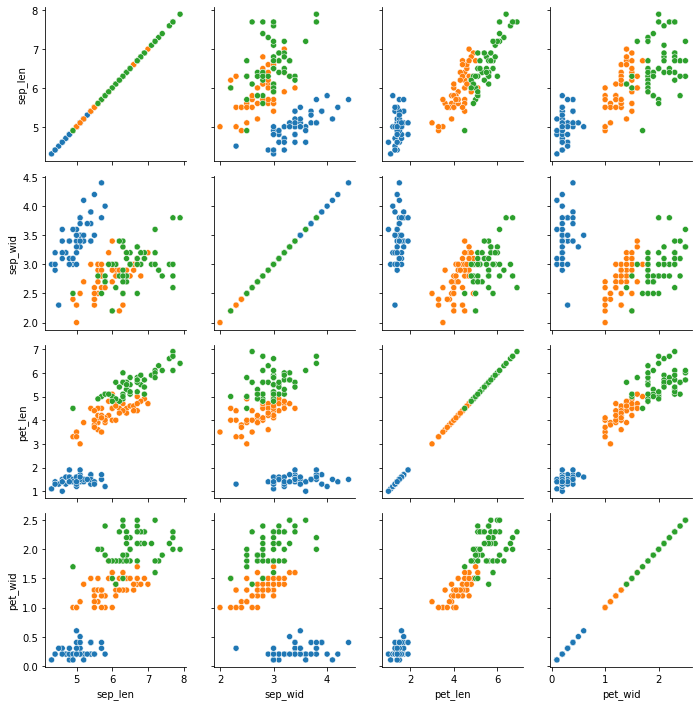

In [89]:
#

import seaborn as sns

iris_plot = df_iris.toPandas()
g = sns.PairGrid(iris_plot, hue="label")
g.map(sns.scatterplot)


Iniciando o Processo de Construção e Aplicação da Árvore de Decisão

In [ ]:
from pyspark.ml.linalg import Vectors  #biblioteca que contém funções de Algebra Linear
from pyspark.ml.feature import VectorAssembler #biblioteca que contém as funções para a construção de vetores

In [ ]:
#criando o vetor de características
vector_assembler = VectorAssembler(inputCols=["sep_len", "sep_wid", "pet_len", "pet_wid"],outputCol="features")
df_temp = vector_assembler.transform(df_iris)
df_temp.show(5)

In [ ]:
#removendo as colunas que não serão utilizadas
df_menor = df_temp.drop('sep_len', 'sep_wid', 'pet_len', 'pet_wid')
df_menor.show(5)

In [ ]:
#aplicando as transformações para a coluna label
from pyspark.ml.feature import StringIndexer  #cria o 'vetor' para cada uma das classes existentes na coluna label

l_indexer = StringIndexer(inputCol="label", outputCol="labelIndex")  #cria o objeto para a codificação
df_final = l_indexer.fit(df_menor).transform(df_menor)  #aplica a transformação

In [ ]:
df_final.show(5)

In [ ]:
#dividindo entre dados de treinamento e teste
(train, test) = df_final.randomSplit([0.7, 0.3])

In [ ]:
test.show(5)

Definindo o Algoritmo

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier  #biblioteca para o algoritmo da árvore de decisão
from pyspark.ml.evaluation import MulticlassClassificationEvaluator  #utilizada para encontrar as métricas de desempenho

In [ ]:
modeloArvore = DecisionTreeClassifier(labelCol="labelIndex", featuresCol="features")  #definindo o modelo
model = modeloArvore.fit(train)  #aplicando o treinamento

In [ ]:
#realizando a previsão
predictions = model.transform(test)
predictions.select("prediction", "labelIndex").show(5)

In [ ]:
#encontrando as métricas de avaliação para o modelo
avaliacao = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction",metricName="accuracy")

In [ ]:
acuracia = avaliacao.evaluate(predictions)
print("Acurácia do Modelo =  ",(acuracia))

Aplicação da Floresta Randômica

In [ ]:
from pyspark.ml.classification import RandomForestClassifier  #classificador para o randomForest


In [ ]:
modeloRF = RandomForestClassifier(labelCol="labelIndex",featuresCol="features", numTrees=10)  #define o modelo
modelRF = modeloRF.fit(train)

In [ ]:
#realizando a previsão
predictions = modelRF.transform(test)
predictions.select("prediction", "labelIndex").show(5)

In [ ]:
#encontrando as métricas de avaliação para o modelo
avaliacao = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction",metricName="accuracy")

In [ ]:
acuracia = avaliacao.evaluate(predictions)
print("Acurácia do Modelo =  ",(acuracia))

In [ ]:
print(modelRF)